## Find the last index of lambda at which Hessian initiation starts to fail
by examining the logging of lambda tuning

In [ ]:
import re
import pandas as pd

def split_and_save_log_file(file_path):
    # Read the contents of the uploaded file
    with open(file_path, 'r') as file:
        log_content = file.read()

    # Splitting the log file into parts for each cell type
    # The pattern to look for is "Starting job for <celltype>"
    celltype_sections = re.split(r"Starting job for ", log_content)

    # The first split will be an empty string or a header, so it should be removed
    celltype_sections = celltype_sections[1:]

    # Process each section
    for section in celltype_sections:
        # Extracting the cell type name (first line of each section)
        celltype_name = section.split('\n', 1)[0].strip()

        # File path for the output file
        output_file_path = f'log_{celltype_name}.txt'

        # Writing the section to the file
        with open(output_file_path, 'w') as file:
            file.write(section)

        print(f"File for '{celltype_name}' saved as: {output_file_path}")

# Example usage
file_path = 'log_5types.txt'  # Replace with your log file path
split_and_save_log_file(file_path)


In [ ]:
def parse_celltype_log(filepath):
    with open(filepath, 'r') as file:
        file_content = file.read()

    # Regular expressions to capture the required information
    celltype_pattern = r"Starting job for (\w+)"
    lambda_pattern = r"Lambda:\s+([\d.]+)"
    outcome_patterns = [
        r"Hessian initialization fail, gradient diff = \d",
        r"Hessian approximation fail, yTs = 0",
        r"OWL-QN did not convergence",
        r"Convergence with loss threshold"
    ]

    # Split the content into sections
    sections = re.split(r"=+\n", file_content)

    # Adjusting the approach to extract all outcomes for 25 lambdas, regardless of the cell type.
    # Since the user is specifically interested in 25 lambda values, we will ensure to capture 25 distinct lambdas.

    # Initialize a new list to hold the extracted data
    all_data = []

    # Process each section to extract lambda and outcome, regardless of celltype
    for section in sections:
        lambda_match = re.search(lambda_pattern, section)
        outcome_match = None
        for outcome_pattern in outcome_patterns:
            outcome_match = re.search(outcome_pattern, section)
            if outcome_match:
                break

        # If matches are found for lambda and outcome, add to the data list
        if lambda_match and outcome_match:
            all_data.append({
                'lambda': float(lambda_match.group(1)),
                'outcome': outcome_match.group(0)
            })

    # Convert the new data list to a DataFrame
    all_df = pd.DataFrame(all_data, columns=['lambda', 'outcome'])

    # Ensure only distinct lambdas are present, and limit to 25 if there are more
    unique_lambdas_df = all_df.drop_duplicates(subset=['lambda']).head(25)

    # Sorting the dataframe by lambda values in ascending order
    outcome_df = unique_lambdas_df.sort_values(by='lambda')
    outcome_df.reset_index(drop=True, inplace=True)

    return outcome_df

In [ ]:
import os

outcome_dict = {}
for file in os.listdir():
    if file.startswith('log_'):
        if file == 'log_5types.txt':
            continue
        celltype_name = file.replace('log_', '').replace('.txt', '')
        outcome_df = parse_celltype_log(file)
        outcome_dict[celltype_name] = outcome_df

In [ ]:
for celltype in outcome_dict.keys():
    print(f"Cell type: {celltype}")
    print(outcome_dict[celltype])
    print('====================')
    print()

In [ ]:
outcome_dict.keys()

In [1]:
# 目測 outcome_dict 裡面的 outcome_df
last_idx_to_keep = {}
last_idx_to_keep['CD4_TCM'] = 13
last_idx_to_keep['B_memory'] = 11
last_idx_to_keep['NK'] = 16
last_idx_to_keep['CD16_Mono'] = 12
last_idx_to_keep['CD4_CTL'] = 10

last_idx_to_keep

{'CD4_TCM': 13, 'B_memory': 11, 'NK': 16, 'CD16_Mono': 12, 'CD4_CTL': 10}

## Ignore section lambda decision

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
sys.path.append('/Users/evanli/Documents/EvanPys/Progress')
from ADlasso2 import AD2_w_utils_loss as ad

In [3]:
# Plot lambda vs. prevalence and lambda vs. loss
# also mark the optimal lambda and the lambda that prevalence start to become 0

def plot_lambda_decision(tuning, celltype, opt_lmbd, cut_idx, savepath=''):
    fig, ax1 = plt.subplots(figsize = (8, 5))
    ax2 = ax1.twinx()

    line1, = ax1.plot(np.exp(tuning['log_lambda_range']), tuning['loss_history'], marker='o', color='blue')
    line2, = ax2.plot(np.exp(tuning['log_lambda_range']), 100*tuning['Prevalence'], marker='o', color='orange')
    ax1.set(xscale="log")
    plt.axvline(x=opt_lmbd, color = 'black', linestyle=':')
    print('Cut:', np.exp(tuning['log_lambda_range'][cut_idx]))
    plt.axvline(x=np.exp(tuning['log_lambda_range'][cut_idx]), color = 'red', linestyle=':')
    ax1.set_xlabel(f"lambda (optimal: {opt_lmbd})")
    ax1.set_ylabel("Loss"); ax2.set_ylabel("Prevalence (%)")
    # ax2.set_ylim(0, 120)
    ax1.set_title(f'{celltype} lambda decision')
    plt.legend(handles=[line1, line2], labels=['BCE loss', 'Prevalence'], loc='upper left')

    if savepath:
        plt.savefig(savepath, dpi=300)

In [4]:
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao/Level2_loss_converge/loss_lambda_tuning_5types')

def ignore_section_lambda_decision(celltype, last_idx):
    print('====================')
    print(f'Cell type: {celltype}')
    with open(f'{celltype}_tuning.json') as f:
        tuning = json.load(f)
        for k in tuning.keys():
            tuning[k] = np.array(tuning[k])
    
    trimmed_tuning = {}
    for k in tuning.keys():
        trimmed_tuning[k] = tuning[k][:last_idx+1]
    
    # Lambda decision from trimmed tuning result
    opt_lmbd, fig = ad.lambda_decision(trimmed_tuning, k=2, savepath=f'./log_analyze_outcome/{celltype}_lambda_decision.png')
    print('Optimal lambda:', opt_lmbd)
    log_opt_lmbd = np.log(opt_lmbd)

    log_lambda_range = tuning['log_lambda_range']
    opt_idx = np.where(log_lambda_range == log_opt_lmbd)[0][0]

    feature_no_celltype = int(tuning['Feature_number'][opt_idx])
    print('Feature no:', feature_no_celltype)

    # Plot lambda vs. prevalence and lambda vs. loss
    plot_lambda_decision(tuning, celltype, opt_lmbd, last_idx+1, savepath=f'./log_analyze_outcome/{celltype}_lambda_decision_all.png')
    
    return opt_lmbd, feature_no_celltype

Cell type: CD4_TCM
Optimal lambda: 0.0014677992676220707
Feature no: 76
Cut: 0.02154434690031885
Cell type: B_memory
Optimal lambda: 0.0006812920690579617
Feature no: 25
Cut: 0.010000000000000005
Cell type: NK
Optimal lambda: 0.006812920690579619
Feature no: 17
Cut: 0.06812920690579614
Cell type: CD16_Mono
Optimal lambda: 0.0021544346900318864
Feature no: 13
Cut: 0.014677992676220709
Cell type: CD4_CTL
Optimal lambda: 0.0003162277660168384
Feature no: 70
Cut: 0.006812920690579619


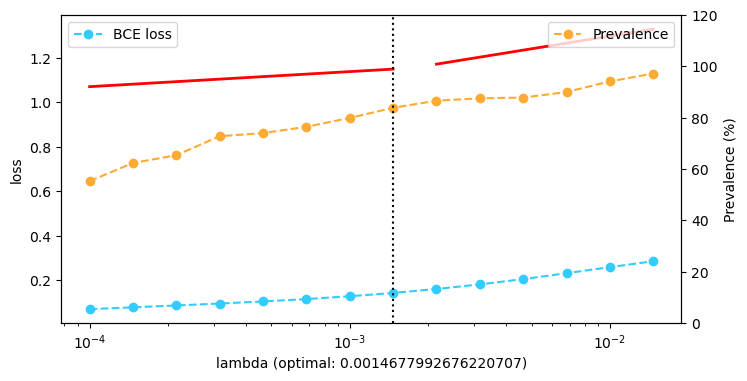

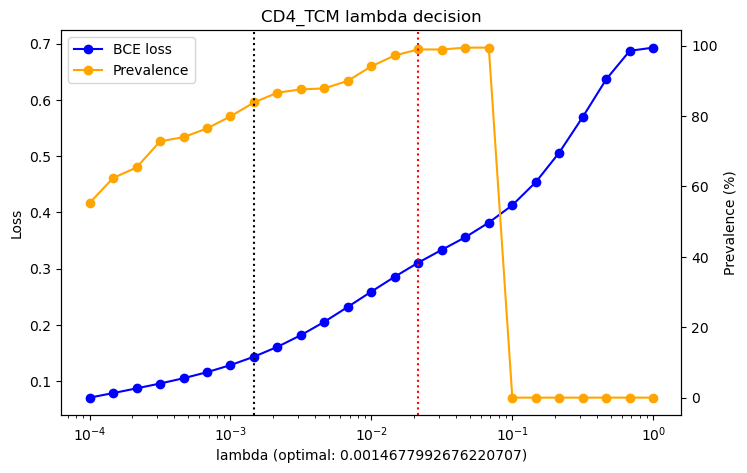

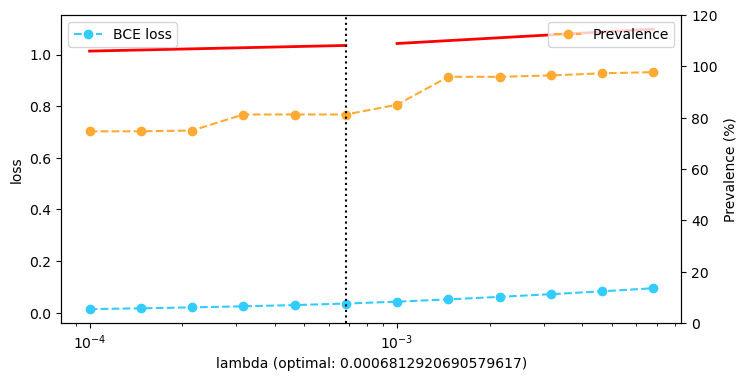

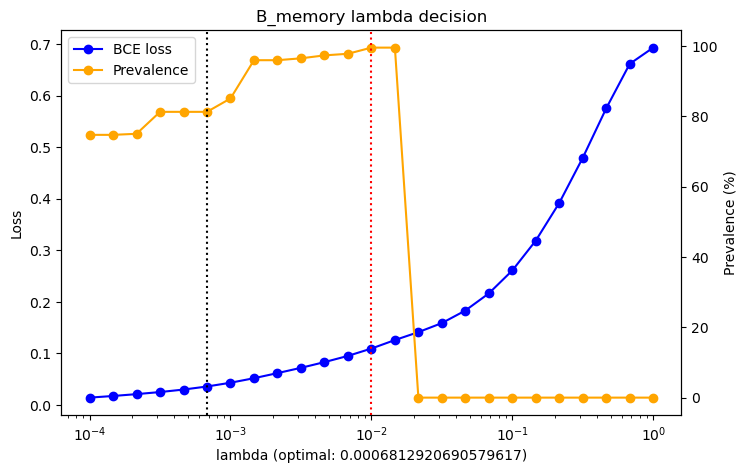

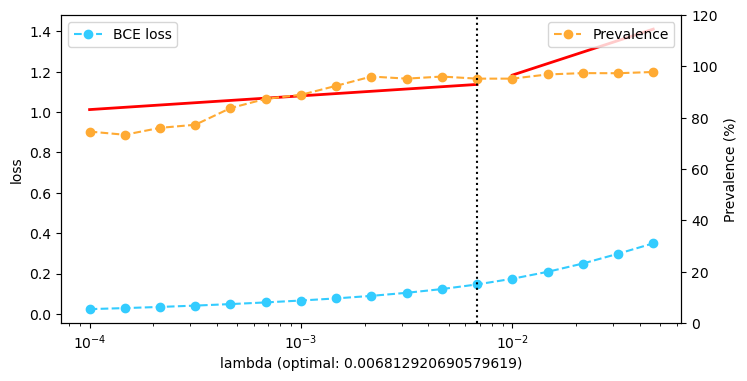

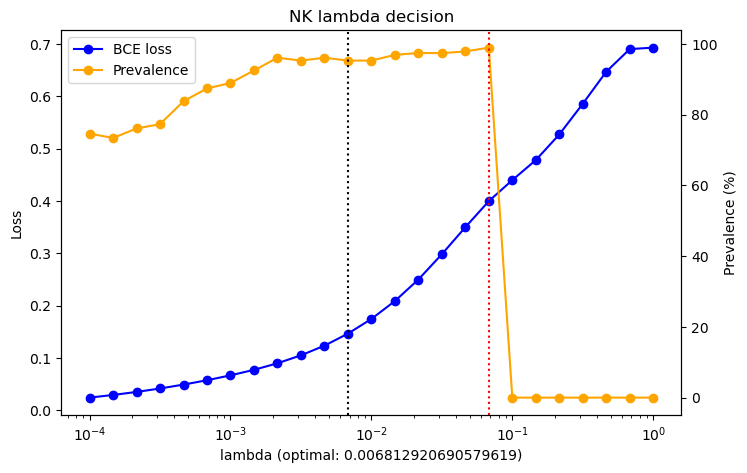

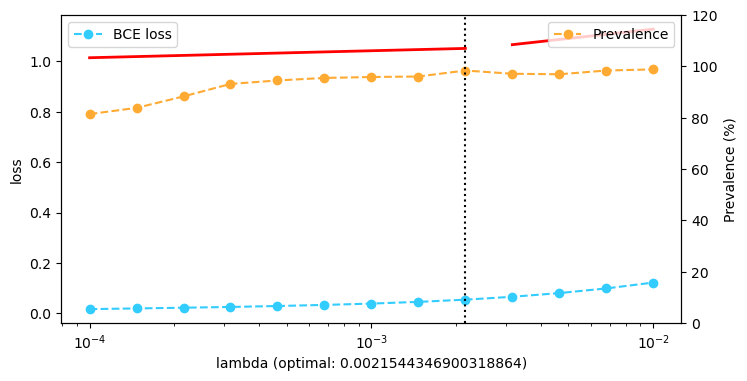

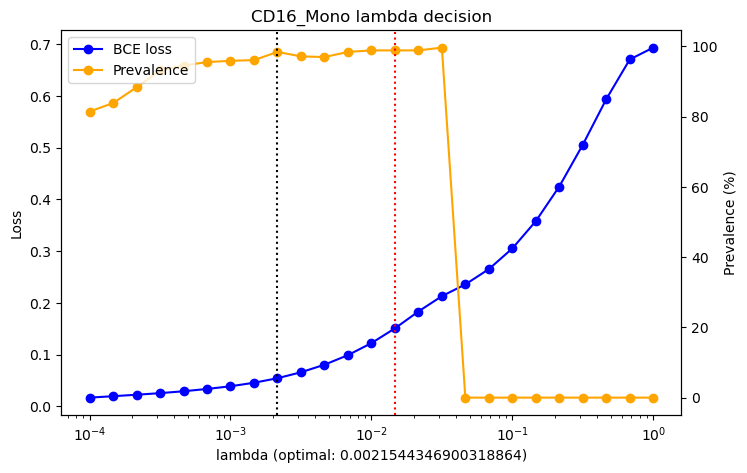

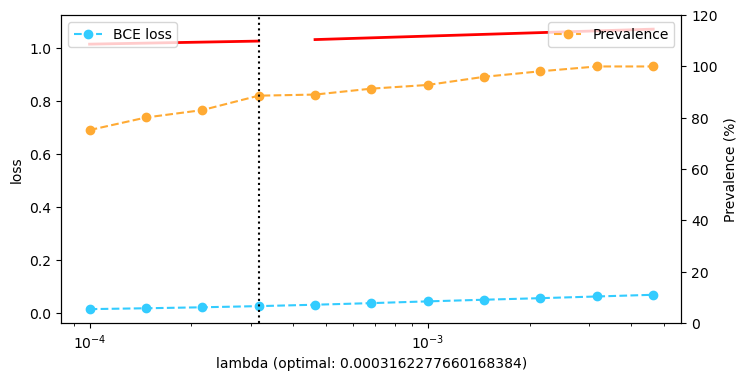

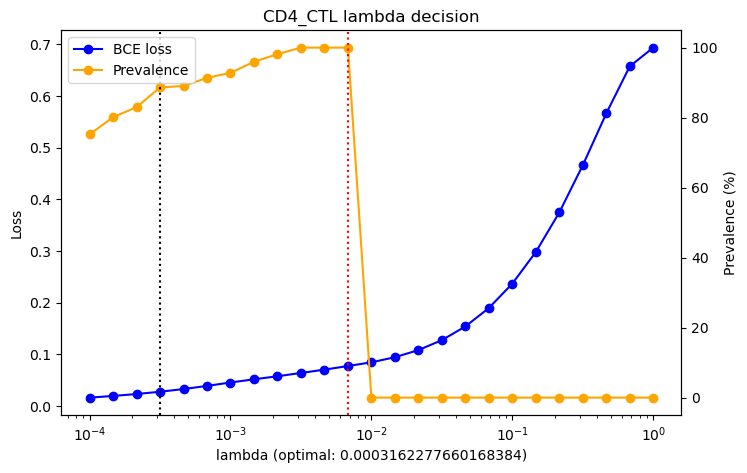

In [5]:
opt_lmbd_dict = {}
feature_no_dict = {}

for celltype in last_idx_to_keep.keys():
    opt_lmbd, feature_no = ignore_section_lambda_decision(celltype, last_idx_to_keep[celltype])
    opt_lmbd_dict[celltype] = opt_lmbd
    feature_no_dict[celltype] = feature_no
    

In [6]:
opt_lmbd_dict

{'CD4_TCM': 0.0014677992676220707,
 'B_memory': 0.0006812920690579617,
 'NK': 0.006812920690579619,
 'CD16_Mono': 0.0021544346900318864,
 'CD4_CTL': 0.0003162277660168384}

In [ ]:
with open('loss_optimal_lambda_5types.json', 'w') as f:
    json.dump(opt_lmbd_dict, f)

## Count features at optimal lambda

In [7]:
feature_no_dict

{'CD4_TCM': 76, 'B_memory': 25, 'NK': 17, 'CD16_Mono': 13, 'CD4_CTL': 70}